### $\color{royalblue}{\text{ Sedma vježba iz numeričkih metoda u astronomiji (NMA), datum: 5.12.2024.}} $

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Math
from mpl_toolkits.mplot3d import Axes3D
import time

### $\color{magenta}{\text{1. NUMERIČKA INTEGRACIJA DIFERENCIJALNIH JEDNAČINA.}} $

Diferencijalne jednačine poput $\dot{y}=f(t,y)$ zahtijevaju pronalaženje funkcije $y(t)$, što je ekvivalentno sa:

#### $y(t)=y(t_0)+\int_{t_0}^tf(s,y(s))ds$.

Numerička integracija je postupak kojim se ovaj integral aproksimira na diskretan način, korak po korak, koristeći razne metode.

### 1.1. Ojlerova metoda.

Neprekidnu funkciju moguće je aproksimirati pomoću polinoma, koristeći vrijednost funkcije i njenih izvoda

u određenoj tački (prema Vajerštrasovoj teoremi, a koristeći npr. Tejlorov polinom):
#### $f(x+\Delta x)=f(x)+\Delta x\cdot f'(x)+\frac{1}{2}(\Delta x)^2\cdot f''(x)+...$
U Ojlerovoj metodi, pretpostavka je da je korak $\Delta x$ dovoljno mali tako da su doprinosi od viših izvoda zanemarljivi.

Dobar primjer su jednačine kretanja:
#### $\vec{r}(t+\Delta t)\approx\vec{r}(t)+\Delta t\cdot\vec{v}(t)$,
#### $\vec{v}(t+\Delta t)\approx\vec{v}(t)+\Delta t\cdot\vec{a}(t)$.
Poznavanjem položaja, brzine i ubrzanja u nekom trenutku vremena možemo da izračunamo njihove vrijednosti 

u nekom budućem trenutku. Pretpostavka je da su poznati početni uslovi (položaj i brzina). Takođe, poznate

su sile koje djeluju, kao i masa, te je moguće izračunati ubrzanje.

Ispod je kod za kreiranje raznih korisnih konverzionih funkcija. Još važnije, data je funkcija koja računa

komponente ubrzanja nekog tijela koje je pod uticajem gravitacije Sunca i planete (potrebno nešto kasnije).

In [306]:
def year2second(x): # konverzija godina u sekunde
    return x*31557600.0

def day2second(x): # konverzija dana u sekunde
    return x*86400

def second2day(x): # konverzija sekunda u dane
    return x/86400

def second2year(x): # konverzija sekunda u godine
    return x/31557600.0

def au2m(x): # konverzija astronomskih jedinica u metre
    return x*au

def m2au(x): # konverzija metara u astronomske jedinice
    return x/au

def ubrzanje_3tijela(x,y,z,xp,yp,zp,Ms,Mp, gama):
    
    # x,y,z - heliocentrične koordinate objekta
    # xp,yp,zp - heliocentrične koordinate planete
    # Ms - masa Sunca
    # Mp - masa planete
    # gama - gravitaciona konstanta
    
    x_pc = x - xp
    y_pc = y - yp
    z_pc = z - zp
    
    r = (x ** 2 + y ** 2 + z ** 2)**(1/2) # heliocentični radijus vektor objekta
    r_pc = (x_pc ** 2 + y_pc ** 2 + z_pc** 2)**(1/2) # planetocentrični radijus vektor objekta


    ax = -gama * (Ms / r**3 * x + Mp / r_pc**3 * x_pc)
    ay = -gama * (Ms / r**3 * y + Mp / r_pc**3 * y_pc)
    az = -gama * (Ms / r**3 * z + Mp / r_pc**3 * z_pc)
    
    return ax, ay, az

gm = 1.32712440018e20 # gravitaciona konstanta * masa Sunca
au = 149597870700.

#### Poželjno je eksperimentisati sa početnim uslovima. Npr. početi sa $x=1\,AJ$ dok su ostale

#### komponente položaja nula (slično i za brzine)... Ovdje je pak drukčije urađeno.

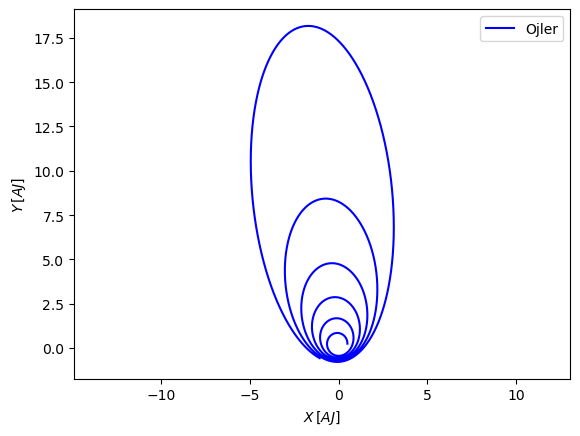

In [240]:
x = [au2m(0.5)] # početni položaji
y = [au2m(0.25)]
z = [0]

vx = [0] # početne brzine
vy = [4e4] 
vz = [1e4]

t = year2second(50) # parametri integracije
dt = day2second(1)

tt = 0

while tt < t:
    
    r = np.sqrt(x[-1]**2 + y[-1]**2 + z[-1]**2) #trenutno heliocentrično rastojanje
    
    # komponente ubrzanja
    ax = -gm/r**3 * x[-1]
    ay = -gm/r**3 * y[-1]
    az = -gm/r**3 * z[-1]
    
    # koordinate
    x.append(x[-1] + vx[-1] * dt)
    y.append(y[-1] + vy[-1] * dt)
    z.append(z[-1] + vz[-1] * dt)
    
    # brzine
    vx.append(vx[-1] + ax * dt)
    vy.append(vy[-1] + ay * dt)
    vz.append(vz[-1] + az * dt)
    
    # vrijeme
    tt = tt + dt
    
plt.plot(m2au(np.array(x)), m2au(np.array(y)),'b', label='Ojler')
plt.axis('equal')
plt.xlabel(r'$X\,[AJ]$')
plt.ylabel(r'$Y\,[AJ]$')
plt.legend()
plt.show()

#### Komentar: Ojlerova metoda može akumulirati grešku tokom duže simulacije, posebno kod orbita

#### koje bi trebalo da budu eliptične. Ta greška se može pojaviti kao "spiralni" odmak orbite.

### 1.2. Ojler-Kromerova metoda.
Modifikacija klasične Ojlerove metode, a glavna razlika je u redosljedu ažuriranja brzina i položaja.

Prvo se ažurira brzina, a položaj se računa iz ažurirane brzine, što daje stabilnije rješenje.
#### $\vec{v}(t+\Delta t)\approx\vec{v}(t)+\Delta t\cdot\vec{a}(t)$,
#### $\vec{r}(t+\Delta t)\approx\vec{r}(t)+\Delta t\cdot\vec{v}(t+\Delta t)$.

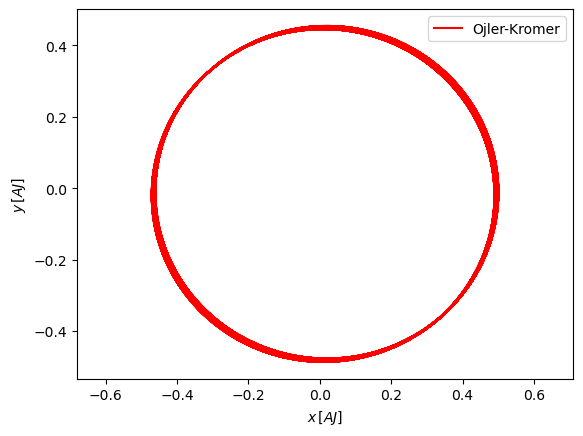

In [241]:
x = [au2m(0.5)] # #početni uslovi
y = [0.25]
z = [0]

vx = [0] # početne brzine
vy = [4e4]
vz = [1e4]

tt = 0
dt = day2second(1)
while tt<t:
    
    r = np.sqrt(x[-1]**2 + y[-1]**2 + z[-1]**2) #trenutno heliocentrično rastojanje
    
    # komponente ubrzanja
    ax = -gm/r**3 * x[-1]
    ay = - gm/r**3 * y[-1]
    az = - gm/r**3 * z[-1]
    
    # brzine
    vx.append(vx[-1] + ax * dt)
    vy.append(vy[-1] + ay * dt)
    vz.append(vz[-1] + az * dt)
    
    # koordinate
    x.append(x[-1] + vx[-1] * dt)
    y.append(y[-1] + vy[-1] * dt)
    z.append(z[-1] + vz[-1] * dt)
    
    # vrijeme
    tt = tt+dt
    
plt.plot(m2au(np.array(x)), m2au(np.array(y)),'r', label='Ojler-Kromer')
plt.axis('equal')
plt.legend()
plt.xlabel('$x\,[AJ]$')
plt.ylabel('$y\,[AJ]$')
plt.legend()
plt.show()

Ojlerova metoda je inferiorna u odnosu na Ojler-Kromerovu metodu jer je nestabilna za velike korake $\Delta t$

i akumulira greške u oscilatornim sistemima. Obje metode su jako jednostavne za primjenu.

### 1.3. Složeniji slučaj.
Sada imamo dva gravitaciona izvora – Sunce i Zemlju. Simulira se putanja tijela zanemarljive mase pod njihovim

uticajem. Uvedene su geocentrične koordinate za praćenje položaja tijela u odnosu na Zemlju ($x_{gc},\,y_{gc},\,z_{gc}$), 

dok su heliocentrične koordinate ($x_{hc},\,y_{hc},\,z_{hc}$) za praćenje položaja tijela u odnosu na Sunce.


In [242]:
Ms = 1.989e30 # masa Sunca
Mz = 5.972e24 # masa Zemlje
gama = 6.67e-11 # gravitaciona konstanta
r0z = 6.378e6  # poluprečnik Zemlje
v_zemlja = 2 * np.pi * au2m(1.) / (365.25 * 86400) # brzina Zemlje
v0 = 1e3 # početna brzina u odnosu na Zemlju

x_hc = [au2m(1.) + 50 * r0z] # 50 Zemljinih poluprečnika od Zemlje
y_hc = [0]
z_hc = [0]
vx_hc = 0.25 * v0
vy_hc = v_zemlja + v0 # heliocentrična brzina tijela
vz_hc = 0.25 * v0

print(x_hc)

[149916770700.0]


In [243]:
start = time.time()

xz = au2m(1) # koordinate Zemlje
yz = 0
zz = 0

sk = 2 * np.pi / year2second(1) # ugaona brzina kretanja Zemlje oko Sunca

x_gc = [x_hc[0] - xz] # geocentrične koordinate objekta
y_gc = [y_hc[0] - yz]
z_gc = [z_hc[0] - zz]

dt = day2second(1/24/6) # korak integracije
t = 0 # početno vrijeme

while t < year2second(1): # jedna godina (eksperimentisati)

    r_hc=(x_hc[-1] ** 2 + y_hc[-1] ** 2 + z_hc[-1] ** 2)**(1/2)
    r_gc=(x_gc[-1] ** 2 + y_gc[-1] ** 2 + z_gc[-1] ** 2)**(1/2)

    ax = -gama * (Ms / r_hc**3 * x_hc[-1] + Mz / r_gc**3 * x_gc[-1])
    ay = -gama * (Ms / r_hc**3 * y_hc[-1] + Mz / r_gc**3 * y_gc[-1])
    az = -gama * (Ms / r_hc**3 * z_hc[-1] + Mz / r_gc**3 * z_gc[-1])

    vx_hc += ax * dt
    vy_hc += ay * dt
    vz_hc += az * dt

    x_hc.append(x_hc[-1] + vx_hc * dt)
    y_hc.append(y_hc[-1] + vy_hc * dt)
    z_hc.append(z_hc[-1] + vz_hc * dt)

    lz = t * sk  # longituda Zemlje 

    # pravougle koordinate Zemlje
    xz = au2m(1.) * np.cos(lz)
    yz = au2m(1.) * np.sin(lz)

    # geocentrične koordinate objekta
    x_gc.append(x_hc[-1] - xz)
    y_gc.append(y_hc[-1] - yz)
    z_gc.append(z_hc[-1] - zz)
    
    t += dt

x_hc = np.array(x_hc)
y_hc = np.array(y_hc)
z_hc = np.array(z_hc)

x_gc = np.array(x_gc)
y_gc = np.array(y_gc)
z_gc = np.array(z_gc)

end = time.time()
print(f'Vrijeme izvršavanja za Ojler-Kromerovu metodu: {end - start:.2f} s.')

Vrijeme izvršavanja za Ojler-Kromerovu metodu: 0.43 s.


Dodatno pojašnjenje prije plotovanja:

Pretpostavlja se da Zemlja kruži oko Sunca po idealnoj kružnoj orbiti sa poluprečnikom od $1\,AJ$. Dakle,

njen položaj se može predstaviti kao:

#### $x=r\cos{\theta},\,y=r\sin{\theta}$,

gdje je $\theta$ trenutna longituda koja se računa kao $\theta=t\cdot sk$, $sk=\frac{2\pi}{god}$, a $sk$ je ugaona brzina Zemlje oko Sunca,

jer Zemlja obiđe $2\pi$ radijana za jednu godinu. Takođe, ovdje se godina konvertuje u sekunde.

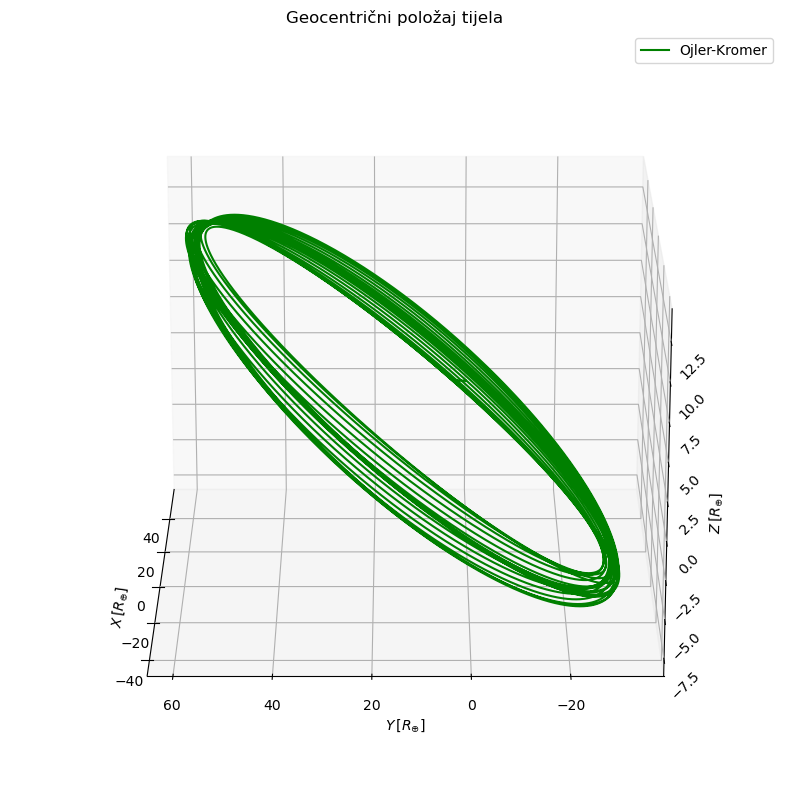

In [244]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

ax.plot(x_gc/r0z, y_gc/r0z, z_gc/r0z, color='g', label='Ojler-Kromer')
ax.set_xlabel(r'$X\,[R_{\oplus}]$')
ax.set_ylabel(r'$Y\,[R_{\oplus}]$')
ax.set_zlabel(r'$Z\,[R_{\oplus}]$')

ax.view_init(elev=20, azim=180)  # zbog preglednosti
ax.zaxis.set_tick_params(labelsize=10, labelrotation=45)
plt.tight_layout()
plt.title('Geocentrični položaj tijela')
plt.legend()
plt.show()

### 1.4. Runge-Kutta metoda.
Da naglasimo, ovdje će biti primjena na složenijem slučaju - simulacija putanje tijela zanemraljive mase pod 

gravitacionim uticajem Sunca i Zemlje. Metodu ćemo nekad nazivati RK4 (postoji npr. RK6 uz druge naprednije varijacije).

Uobičajeno, rješava se jednačina:
#### $\frac{dy}{dt}=f(t,y)$.
Naravno, važe i jednakosti:
#### $dy=f(t,y)\cdot dt$, $\Delta y=f(t,y)\cdot\Delta t$.
Runge-Kutta metoda koristi procjene promjene funkcije (izvoda) unutar jednog koraka kako bi se odredio sljedeći položaj.

Procjene su izvedene na početku, sredini i kraju vremenskog koraka, što omogućava visok stepen preciznosti. 

Metoda aproksimira vrijednost $y(t+\Delta t)$ koristeći formulu:
#### $y_{n+1}=y_n+\frac{1}{6}(K_1+2K_2+2K_3+K_4)$,
gdje su koeficijenti $K_i$ procjene promjene funkcije u različitim tačkama unutar koraka.

Faktor $1/6$ dolazi iz zahtjeva da metoda bude četvrtog reda tačnosti, što se postiže preciznim ponderisanjem $K_i$.

Takođe, dvije srednje procjene imaju dvostruku težinu (faktor 2) jer srednje tačke bolje reprezentuju ukupni doprinos.

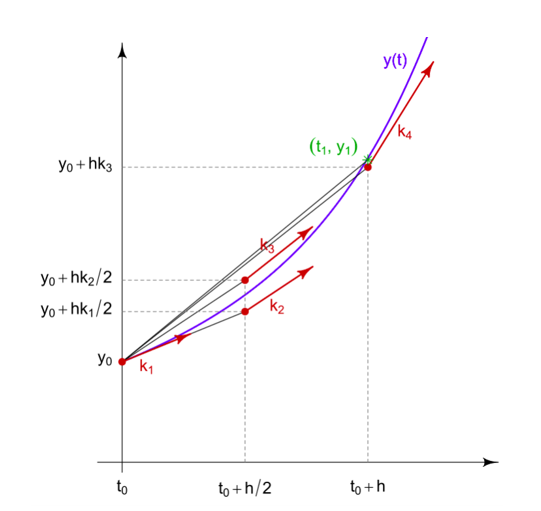

#### Koraci RK4 metode su:

1. korak (početna procjena stope promjene, pretpostavka je da je funkcija linearna, kao kod Ojlerove metode):

$K_1 = \Delta t \cdot f(t, y)$.

2. korak (procjena stope promjene na sredini intervala, koristeći $K_1$ - uzima se u obzir da je funkcija u toj

tački već porasla sa stopom $K_1$):

$K_2 = \Delta t \cdot f\left(t + \frac{\Delta t}{2}, y + \frac{K_1}{2}\right)$.

3. korak (procjena stope promjene na sredini intervala, koristeći  $K_2$ - uzima se u obzir da je funkcija u toj

tački već porasla sa stopom $K_2$):

$K_3 = \Delta t \cdot f\left(t + \frac{\Delta t}{2}, y + \frac{K_2}{2}\right)$.

4. korak (procjena stope promene na kraju intervala, koristeći $K_3$ - uzima se u obzir da je funkcija u toj

tački već porasla sa stopom $K_3$):

$K_4 = \Delta t \cdot f(t + \Delta t, y + K_3)$.

Na kraju se iz dobijenih koeficijenata računa $y_{n+1}$.


#### Rješavanje sistema jednačina drugog reda Runge-Kutta metodom opisano je ispod. 
Ovo je primjer koji je nama interesantan.
$$
\ddot{x} = \frac{-\gamma M}{(x^2 + y^2 + z^2)^{\frac{3}{2}}} x, 
$$

$$
\ddot{y} = \frac{-\gamma M}{(x^2 + y^2 + z^2)^{\frac{3}{2}}} y, 
$$

$$
\ddot{z} = \frac{-\gamma M}{(x^2 + y^2 + z^2)^{\frac{3}{2}}} z, 
$$

$$
\dot{x} = v_x, \quad \dot{y} = v_y, \quad \dot{z} = v_z
$$

$$
\dot{v}_x = \frac{-\gamma M}{(x^2 + y^2 + z^2)^{\frac{3}{2}}} x, \quad 
\dot{v}_y = \frac{-\gamma M}{(x^2 + y^2 + z^2)^{\frac{3}{2}}} y, \quad 
\dot{v}_z = \frac{-\gamma M}{(x^2 + y^2 + z^2)^{\frac{3}{2}}} z
$$

$$
k_1 = \Delta t \cdot f(t, x)
$$

$$
k_{1(x)} = \Delta t \cdot f(v_x)
$$

$$
k_{1(v_x)} = \Delta t \cdot f(x, y, z)
$$

$$
k_{1(x)} = \Delta t \cdot v_x
$$

$$
k_{1(v_x)} = \Delta t \cdot \left(\frac{-\gamma M}{(x^2 + y^2 + z^2)^{\frac{3}{2}}} x \right)
$$


$$
k_2 = \Delta t \cdot f\left(t + \frac{\Delta t}{2}, x + \frac{k_1}{2}\right)
$$

$$
k_3 = \Delta t \cdot f\left(x + \frac{k_2}{2}\right)
$$

$$
k_4 = \Delta t \cdot f(x + k_3)
$$

$$
x_{n+1} = x_n + \frac{1}{6} \left( k_{1(x)} + 2k_{2(x)} + 2k_{3(x)} + k_{4(x)} \right)
$$

$$
v_{x(n+1)} = v_{x(n)} + \frac{1}{6} \left( k_{1(v_x)} + 2k_{2(v_x)} + 2k_{3(v_x)} + k_{4(v_x)} \right)
$$

Sada, konačno prelazimo na kod.

In [245]:
start = time.time()

x = au2m(1.) + 50 * r0z # početni uslovi
y = 0
z = 0
vx = 0.25 * v0
vy = v_zemlja + v0
vz = 0.25 * v0

x_zemlja = au2m(1.)
y_zemlja = 0
z_zemlja = 0

sk = 2 * np.pi / year2second(1.)  # ugaona brzina Zemlje

t = 0.  # početno vrijeme
dt = day2second(1/24/6)  # korak integracije 10 minuta

x_rk = [x - x_zemlja] # čuvanje rezultata
y_rk = [y - y_zemlja]
z_rk = [z - z_zemlja]

vrijeme = [0]

while t < year2second(1): # jedna godina (eksperimentisati)

    # 1. korak
    ax, ay, az = ubrzanje_3tijela(x, y, z, x_zemlja, y_zemlja, z_zemlja, Ms, Mz, gama)
    Kx_1 = dt * vx
    Ky_1 = dt * vy
    Kz_1 = dt * vz
    Kvx_1 = dt * ax
    Kvy_1 = dt * ay
    Kvz_1 = dt * az

    # 2. korak
    ax, ay, az = ubrzanje_3tijela(x + Kx_1 / 2, y + Ky_1 / 2, z + Kz_1 / 2,
                                x_zemlja, y_zemlja, z_zemlja, Ms, Mz, gama)
    Kx_2 = dt * (vx + Kvx_1 / 2)
    Ky_2 = dt * (vy + Kvy_1 / 2)
    Kz_2 = dt * (vz + Kvz_1 / 2)
    Kvx_2 = dt * ax
    Kvy_2 = dt * ay
    Kvz_2 = dt * az

    # 3. korak
    ax, ay, az = ubrzanje_3tijela(x + Kx_2 / 2, y + Ky_2 / 2, z + Kz_2 / 2,
                                x_zemlja, y_zemlja, z_zemlja, Ms, Mz, gama)
    Kx_3 = dt * (vx + Kvx_2 / 2)
    Ky_3 = dt * (vy + Kvy_2 / 2)
    Kz_3 = dt * (vz + Kvz_2 / 2)
    Kvx_3 = dt * ax
    Kvy_3 = dt * ay
    Kvz_3 = dt * az

    # 4. korak
    ax, ay, az = ubrzanje_3tijela(x + Kx_3, y + Ky_3, z + Kz_3,
                                x_zemlja, y_zemlja, z_zemlja, Ms, Mz, gama)
    Kx_4 = dt * (vx + Kvx_3)
    Ky_4 = dt * (vy + Kvy_3)
    Kz_4 = dt * (vz + Kvz_3)
    Kvx_4 = dt * ax
    Kvy_4 = dt * ay
    Kvz_4 = dt * az

    # ažuriranje pozicija i brzina
    x += (Kx_1 + 2 * Kx_2 + 2 * Kx_3 + Kx_4) / 6
    y += (Ky_1 + 2 * Ky_2 + 2 * Ky_3 + Ky_4) / 6
    z += (Kz_1 + 2 * Kz_2 + 2 * Kz_3 + Kz_4) / 6
    vx += (Kvx_1 + 2 * Kvx_2 + 2 * Kvx_3 + Kvx_4) / 6
    vy += (Kvy_1 + 2 * Kvy_2 + 2 * Kvy_3 + Kvy_4) / 6
    vz += (Kvz_1 + 2 * Kvz_2 + 2 * Kvz_3 + Kvz_4) / 6

    # ažuriranje položaja Zemlje
    t += dt
    x_zemlja = au2m(1.) * np.cos(sk * t)
    y_zemlja = au2m(1.) * np.sin(sk * t)

    # čuvanje geocentričnih koordinata
    x_rk.append(x - x_zemlja)
    y_rk.append(y - y_zemlja)
    z_rk.append(z - z_zemlja)
    vrijeme.append(t)
    
end = time.time()
print(f'Vrijeme izvršavanja za Runge-Kutta metodu: {end - start:.2f} s.')

Vrijeme izvršavanja za Runge-Kutta metodu: 1.17 s.


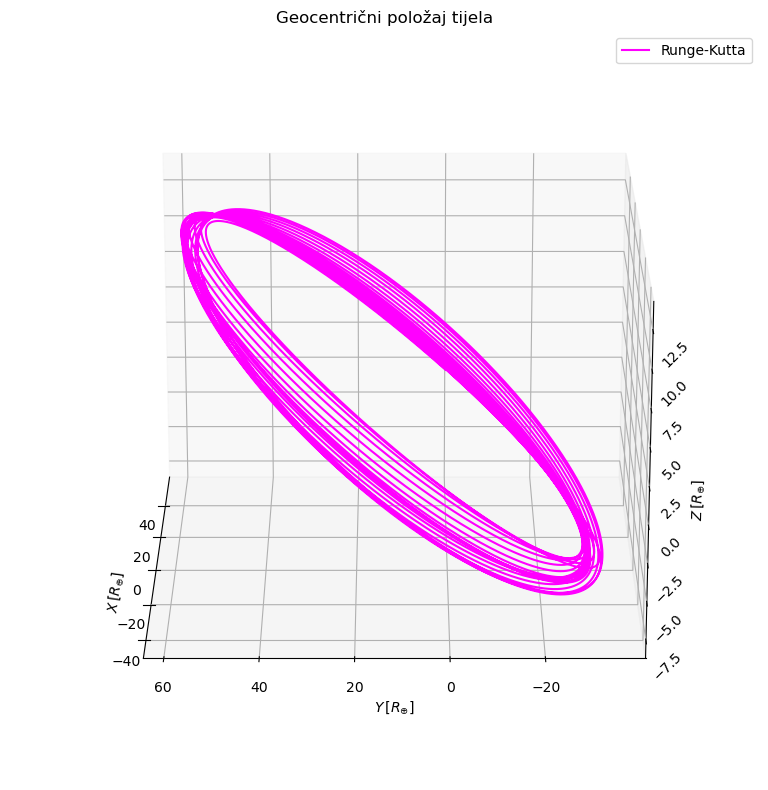

In [246]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.plot(np.array(x_rk)/r0z, np.array(y_rk)/r0z, np.array(z_rk)/r0z, color='magenta',
        label='Runge-Kutta')

ax.view_init(elev=20, azim=180)  # zbog preglednosti
ax.zaxis.set_tick_params(labelsize=10, labelrotation=45)
ax.set_xlabel(r'$X\,[R_{\oplus}]$')
ax.set_ylabel(r'$Y\,[R_{\oplus}]$')
ax.set_zlabel(r'$Z\,[R_{\oplus}]$')
plt.title('Geocentrični položaj tijela')

plt.tight_layout()
plt.legend()
plt.show()

### 1.5. Upoređivanje Ojler-Kromerove i Runge-Kutta metode.

In [247]:
print("Ojler-Kromer krajnje koordinate:")
print(x_gc[-1], y_gc[-1], z_gc[-1])

print("Runge-Kutta krajnje koordinate:")
print(x_rk[-1], y_rk[-1], z_rk[-1])

Ojler-Kromer krajnje koordinate:
-52487709.65805054 347926086.09760576 79312368.66916257
Runge-Kutta krajnje koordinate:
-81137342.26855469 325190749.28519046 71949474.60508981


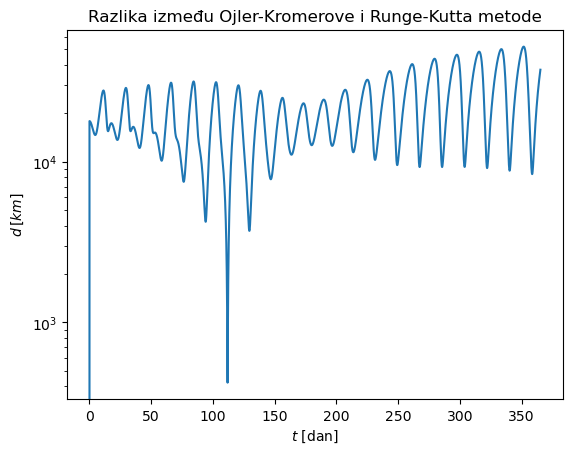

In [248]:
dx = np.array(x_rk) - x_gc
dy = np.array(y_rk) - y_gc
dz = np.array(z_rk) - z_gc

d = np.sqrt(dx**2 + dy**2 + dz**2)

plt.plot(second2day(np.array(vrijeme)), d/1000)
plt.yscale('log') # logaritamska skala
plt.xlabel(r'$t$ [dan]')
plt.ylabel(r'$d\,[km]$')
plt.title('Razlika između Ojler-Kromerove i Runge-Kutta metode')
plt.show()

#### Korisno je prikazati relativnu grešku:
#### $\varepsilon=\frac{d_{RK}-d_{OK}}{d_{RK}}$.

Maksimalna relativna greška: 21.38 %


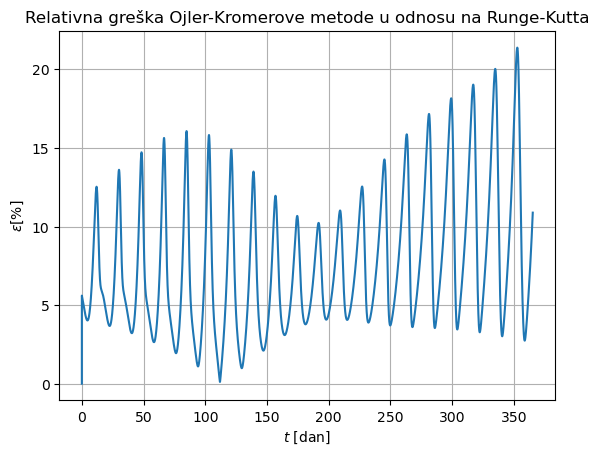

In [253]:
dx = np.array(x_rk) - np.array(x_gc) 
dy = np.array(y_rk) - np.array(y_gc)
dz = np.array(z_rk) - np.array(z_gc)

d = np.sqrt(dx**2 + dy**2 + dz**2)

relativna_greska = d / np.sqrt(np.array(x_rk)**2 + np.array(y_rk)**2 + np.array(z_rk)**2)

max_rg = np.max(relativna_greska) * 100
print(f'Maksimalna relativna greška: {max_rg:.2f} %')

plt.plot(second2day(np.array(vrijeme)), relativna_greska * 100)  # Greška u %

plt.xlabel(r'$t$ [dan]')
plt.ylabel(r'$\varepsilon [\%]$')
plt.title('Relativna greška Ojler-Kromerove metode u odnosu na Runge-Kutta')
plt.grid()
plt.show()

### 1.6. Dodatni primjer (sa uključenim analitičkim rješenjem).
Analitičko rješenje kretanja tijela pod gravitacionim uticajem Sunca poredi se sa numeričkim rješenjima 

dobijenim različitim metodama koje smo ranije spominjali.

Potrebna nam je funkcija za numeričko rješavanje Keplerove jednačine:
#### $M=E-e\sin{E}$,
gdje je $M$ srednja anomalija, a $E$ je ekscentrična anomalija. Iterativni proces je Njutn-Rafson metoda:
#### $E_{novo}=E_{staro}-\frac{f(E_{staro})}{f'(E_{staro})}$.

In [307]:
def kepler(e,M,tacnost):
    delta = 2 * tacnost
    E = M
    while np.abs(delta) > tacnost:
        f = E - e * np.sin(E) - M
        fprim = 1 - e * np.cos(E)
        delta = f/fprim
        E = E - delta
    return(E)

#### Radi podsjećanja navodimo i jednačine:
#### $a=\frac{1}{\frac{2}{r}-\frac{v^2}{GM}}$, $e=1-\frac{r}{a}$.

In [327]:
x = au # početni uslovi
y = 0
z = 0
vx = 0
vy = 4e4

a = 1/(2/x - vy**2/Ms/gama) # velika poluosa
e = 1 - x/a # ekscentricitet
f = np.linspace(0, 2 * np.pi, 1000) # prava anomalija 
r = a * (1 - e**2)/(1 + e*np.cos(f)) # orbitalni radijus

X_analiticki = r * np.cos(f) # primjer toga kako se dobija orbita
Y_analiticki = r * np.sin(f)

#### Definišemo dužinu integracije i funkciju ubrzanja - potrebno za numeričke metode.

In [337]:
T = np.sqrt(4 * np.pi**2 * a**3/Ms/gama) # orbitalni period

t_lim = 10 * T 
dt = day2second(10.) # korak integracije

def ubrzanje(x,y, Ms, gama):

    r=(x ** 2 + y ** 2)**(1/2) # heliocentični radijus vektor objekta
   
    ax = -gama * (Ms / r**3 * x)
    ay = -gama * (Ms / r**3 * y)
 
    return ax, ay

In [329]:
# Računanje položaja tijela na Keplerovoj orbiti koristeći analitičko rješenje

n = np.sqrt(Ms * gama/a ** 3) # prosječna ugaona brzina (nekad sr. dnevno kretanje)
x_a = []
y_a = []
t = 0

while t < t_lim:
    
    M = t * n
    E = kepler(e, M, 1e-6)
    x_a.append(a * (np.cos(E) - e))
    y_a.append(a * np.sqrt(1 - e**2) * np.sin(E))  
    t += dt
    
x_a = np.array(x_a)
y_a = np.array(y_a)

#### Numeričke metode i plotovanje usput.

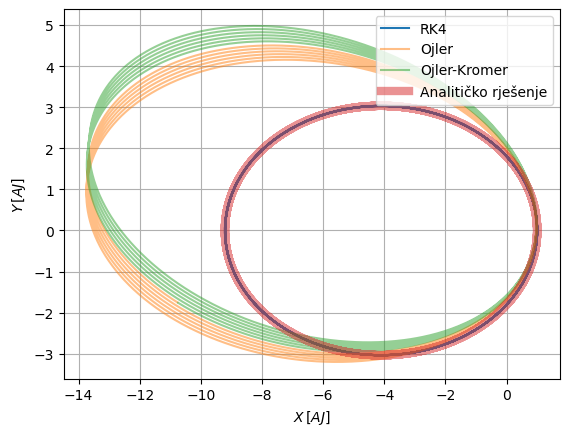

In [330]:
# Runge-Kutta metoda

pocetak = time.time()

t = 0
x_rk = []
y_rk = []

while t < t_lim:

    xx = x
    vxx = vx
    yy = y
    vyy = vy

    # 1. korak
    Kx_1 = dt * vxx
    Kvx_1 = dt * ubrzanje(xx, yy, Ms, gama)[0]
    Ky_1 = dt * vyy
    Kvy_1 = dt * ubrzanje(xx, yy, Ms, gama)[1]

    xx = x + Kx_1/2
    vxx = vx + Kvx_1/2
    yy = y + Ky_1/2
    vyy = vy + Kvy_1/2

    # 2. korak
    Kx_2 = dt * vxx
    Kvx_2 = dt * ubrzanje(xx, yy, Ms, gama)[0]
    Ky_2 = dt * vyy
    Kvy_2 = dt * ubrzanje(xx, yy, Ms, gama)[1]

    xx = x + Kx_2/2
    vxx = vx + Kvx_2/2
    yy = y + Ky_2/2
    vyy = vy + Kvy_2/2

    # 3. korak
    Kx_3 = dt * vxx
    Kvx_3 = dt * ubrzanje(xx, yy, Ms, gama)[0]
    Ky_3 = dt * vyy
    Kvy_3 = dt * ubrzanje(xx, yy, Ms, gama)[1]

    xx = x + Kx_3
    vxx = vx + Kvx_3
    yy = y + Ky_3
    vyy = vy + Kvy_3

    # 4. korak
    Kx_4 = dt * vxx
    Kvx_4 = dt * ubrzanje(xx, yy, Ms, gama)[0]
    Ky_4 = dt * vyy
    Kvy_4 = dt * ubrzanje(xx, yy, Ms, gama)[1]
    
    # računanje koeficijenata K
    Kx = 1/6 * (Kx_1 + 2 * Kx_2 + 2 * Kx_3 + Kx_4)
    Kvx = 1/6 * (Kvx_1 + 2 * Kvx_2 + 2 * Kvx_3 + Kvx_4)
    Ky = 1/6 * (Ky_1 + 2 * Ky_2 + 2 * Ky_3 + Ky_4)
    Kvy = 1/6 * (Kvy_1 + 2 * Kvy_2 + 2 * Kvy_3 + Kvy_4)
  
    x = x + Kx
    vx = vx + Kvx
    y = y + Ky
    vy = vy + Kvy
    
    x_rk.append(x)
    y_rk.append(y)
    t += dt

vrijeme_rk = time.time() - pocetak
    
plt.plot(np.array(x_rk)/au, np.array(y_rk)/au, label='RK4') 

################################################################################

# Ojlerova metoda

pocetak = time.time()

x_o = []
y_o = []
t = 0

while t < t_lim:
    
  
    x += dt * vx
    y += dt * vy
    vx += dt * ubrzanje(x, y, Ms, gama)[0]
    vy += dt * ubrzanje(x, y, Ms, gama)[1]
   
    x_o.append(x)
    y_o.append(y)
    t += dt
 
vrijeme_o = time.time() - pocetak

plt.plot(np.array(x_o)/au, np.array(y_o)/au, label='Ojler', alpha=0.5) 

################################################################################

# Ojler-Kromer

pocetak = time.time()

x_ok = []
y_ok = []
z_ok = []
t = 0

while t < t_lim:
    
    vx += dt * ubrzanje(x, y, Ms, gama)[0]
    vy += dt * ubrzanje(x, y, Ms, gama)[1]
    x += dt * vx
    y += dt * vy

    x_ok.append(x)
    y_ok.append(y)
    z_ok.append(z)
    t += dt

vrijeme_ok = time.time() - pocetak
 
plt.plot(np.array(x_ok)/au,np.array(y_ok)/au, label='Ojler-Kromer', alpha=0.5)  

################################################################################

# Analitička metoda i plot

plt.plot(x_a/au, y_a/au, label='Analitičko rješenje',
         alpha=0.5, linewidth=6)

plt.grid()
plt.xlabel(r'$X\,[AJ]$')
plt.ylabel(r'$Y\,[AJ]$')
plt.legend() 
plt.show()

In [331]:
print(vrijeme_rk, vrijeme_o, vrijeme_ok) # vremena izvršavanja

0.07071137428283691 0.008068323135375977 0.008165836334228516


In [335]:
x_rk = np.array(x_rk) # konverzija listi koordinata u nizove
y_rk = np.array(y_rk)
x_o = np.array(x_o)
y_o = np.array(y_o)
x_ok = np.array(x_ok)
y_ok = np.array(y_ok)

#### Upoređivanje metoda. 
Možemo naći apsolutnu grešku iz formule:
$
\Delta = \sqrt{(x_{\text{A}} - x_{\text{N}})^2 + (y_{\text{A}} - y_{\text{N}})^2},
$

gdje je indeks $A$ oznaka za analitički, a indeks $N$ za numerički dio.

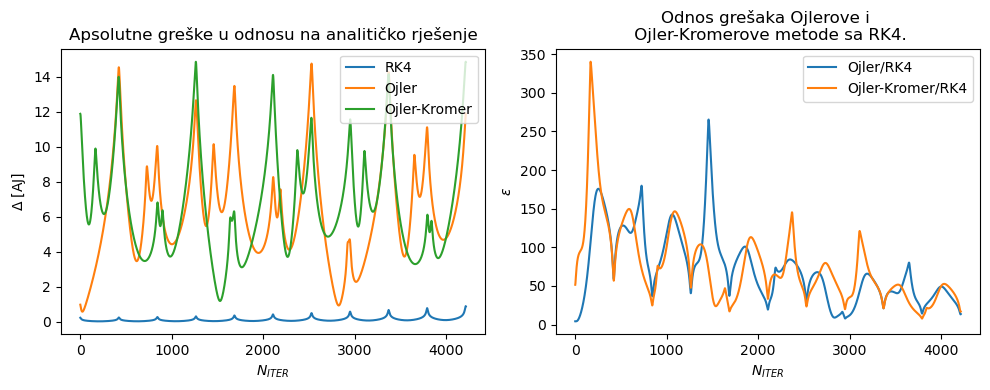

In [338]:
delta_rk = np.sqrt((x_a - x_rk)**2 + (y_a - y_rk)**2) # apsolutne greške
delta_o = np.sqrt((x_a - x_o)**2 + (y_a - y_o)**2)
delta_ok = np.sqrt((x_a - x_ok)**2 + (y_a - y_ok)**2)

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(delta_rk/au,label='RK4')
plt.plot(delta_o/au,label='Ojler')
plt.plot(delta_ok/au,label='Ojler-Kromer')
plt.xlabel(r'$N_{ITER}$')
plt.ylabel(r'$\Delta$ [AJ]')
plt.title('Apsolutne greške u odnosu na analitičko rješenje')
plt.legend()

plt.subplot(122)
plt.plot(delta_o/delta_rk, label='Ojler/RK4')
plt.plot(delta_ok/delta_rk, label='Ojler-Kromer/RK4')
plt.xlabel(r'$N_{ITER}$')
plt.ylabel(r'$\varepsilon$')
plt.title('Odnos grešaka Ojlerove i \n Ojler-Kromerove metode sa RK4.')
plt.legend()

plt.tight_layout()
plt.show()

### 1.7. Zaključak:
Ojlerova metoda je najjednostavnija metoda za rješavanje diferencijalnih jednačina, a veoma se lako implementira.

Korisna je u slučaju kad je potreban "grub" uvid u dinamiku sistema. Međutim, ima dosta nedostataka,

poput neočuvanja energije u konzervativnim sistemima. Položaj se računa na osnovu trenutne brzine, a ta brzina

nije korigovana efektima ubrzanja tokom cijelog koraka, pa se greška akumulira. Ojlerova metoda se pak,

može koristiti za sisteme koji nisu konzervativni (npr. gdje postoji prigušenje). Ojler-Kromerova metoda

bolje očuva konzervativne osobine sistema (energiju i ugaoni moment), a kod orbita, to znači da će tijelo

nastaviti da kruži oko Sunca ili Zemlje bez "spiralnog" napuštanja orbite.

Runge-Kutta metoda (4. reda) zahtijeva manje koraka za postizanje iste tačnosti kao Ojler-Kromerova metoda. 

Radi sporije, ali je akumulacija grešaka manja. Takođe, RK4 metoda je pogodna za duže simulacije (stabilnija je).

#### Vježba: 
Provjeriti šta se dešava sa energijom i momentom impulsa u simulaciji orbite tijela zanemarljive mase pod gravitacionim 

uticajem Sunca i planete.
